In [1]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/modules/'
import sys
sys.path.append(module_path)
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import model_management

np.random.seed(999)
random.seed(999)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
### General parameters
run_on_cpu = False
nEpochs = 1e3
batchSize = 1e4
total_set_size = 300000 # how many examples will be used for training+validation+testing
train_size = 270000
val_size = 10000
test_size = 10000
early_stopping_param = 5
input_features = ['Halo_mass', 'Halo_mass_peak', 'Concentration', 'Type', 'Scale_peak_mass', 'Scale_half_mass', 
                 'Scale_last_MajM']
output_features = ['Stellar_mass', 'SFR']
save_figs = 1
fig_dir = 'figures/'

### Network parameters
nLayers = 20
activationFunction = 'tanh'
neuronsPerLayer = 20
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'

data_dict = {'X_pos': 0, 'Y_pos': 1, 'Z_pos': 2, 'X_vel': 3, 'Y_vel': 4, 'Z_vel': 5, 'Halo_mass': 6, 
             'Stellar_mass': 7, 'SFR': 8, 'Intra_cluster_mass': 9, 'Halo_mass_peak': 10, 'Stellar_mass_obs': 11, 
             'SFR_obs': 12, 'Halo_radius': 13, 'Concentration': 14, 'Halo_spin': 15, 'Scale_peak_mass': 16, 
             'Scale_half_mass': 17, 'Scale_last_MajM': 18, 'Type': 19}
unit_dict = {'X_pos': '', 'Y_pos': '', 'Z_pos': '', 'X_vel': '', 'Y_vel': '', 
             'Z_vel': '', 'Halo_mass': 'log($M_{G}/M_{S}$)', 'Stellar_mass': 'log($M_{G}/M_{S}$)', 'SFR': '', 
             'Intra_cluster_mass': '', 'Halo_mass_peak': 'log($M_{G}/M_{S}$)', 
             'Stellar_mass_obs': '', 'SFR_obs': '', 'Halo_radius': '', 
             'Concentration': '', 'Halo_spin': '', 'Scale_peak_mass': 'a', 
             'Scale_half_mass': 'a', 'Scale_last_MajM': 'a', 'Type': ''}

In [17]:
if run_on_cpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [18]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

nLayers_20_nNeurons_20_actFun_tanh_lossFunc_mse_nTrainSamples_270000_nEpochs_1000_batchSize_10000


# Load and preprocess the data

In [19]:
galfile = pd.read_hdf('/scratch/data/galcats/P200/galaxies.Z01.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()

### Remove data points with halo mass below 10.5
print(np.shape(galaxies))
galaxies = galaxies[galaxies[:,6] > 10.5, :]
print(np.shape(galaxies))
print(galaxies[:10,6])

halo_min_mass = np.min(galaxies[:, 6])
halo_max_mass = np.max(galaxies[:, 6])

(594946, 20)
(306925, 20)
[11.06128  10.74806  10.517851 11.935673 11.820144 11.564987 10.759135
 10.828308 10.803138 10.55098 ]


In [20]:
n_data_points = galaxies.shape[0]
subset_indices = np.random.choice(n_data_points, total_set_size, replace=False)
train_indices = subset_indices[: int(train_size)]
val_indices = subset_indices[int(train_size) : int(train_size+val_size)]
test_indices = subset_indices[int(train_size+val_size) :]

x_train = np.zeros((len(train_indices), len(input_features)))
x_val = np.zeros((len(val_indices), len(input_features)))
x_test = np.zeros((len(test_indices), len(input_features)))
y_train = np.zeros((len(train_indices), len(output_features)))
y_val = np.zeros((len(val_indices), len(output_features)))
y_test = np.zeros((len(test_indices), len(output_features)))

for i in range(len(input_features)):
    x_train[:,i] = galaxies[train_indices, data_dict[input_features[i]]]
    x_val[:,i] = galaxies[val_indices, data_dict[input_features[i]]]
    x_test[:,i] = galaxies[test_indices, data_dict[input_features[i]]]
    
for i in range(len(output_features)):
    y_train[:,i] = galaxies[train_indices, data_dict[output_features[i]]]
    y_val[:,i] = galaxies[val_indices, data_dict[output_features[i]]]
    y_test[:,i] = galaxies[test_indices, data_dict[output_features[i]]]

In [21]:
### ZERO MEAN, UNIT STD

norm = 'zero_mean_unit_std_norm'

for i in range(np.size(x_train, 1)):
    x_data_means = np.mean(x_train, 0)
    x_data_stds = np.std(x_train, 0)

    x_train_norm = (x_train - x_data_means) / x_data_stds
    x_val_norm = (x_val - x_data_means) / x_data_stds
    x_test_norm = (x_test - x_data_means) / x_data_stds

for i in range(np.size(y_train, 1)):
    y_data_means = np.mean(y_train, 0)
    y_data_stds = np.std(y_train, 0)

    y_train_norm = (y_train - y_data_means) / y_data_stds
    y_val_norm = (y_val - y_data_means) / y_data_stds
    y_test_norm = (y_test - y_data_means) / y_data_stds

In [58]:
### BETWEEN ZERO AND ONE

norm = 'zero_to_one_norm'

for i in range(np.size(x_train, 1)):
    x_data_max = np.max(x_train, 0)
    x_data_min = np.min(x_train, 0)

    x_train_norm = (x_train - x_data_min) / (x_data_max - x_data_min)
    x_val_norm = (x_val - x_data_min) / (x_data_max - x_data_min)
    x_test_norm = (x_test - x_data_min) / (x_data_max - x_data_min)

for i in range(np.size(y_train, 1)):
    y_data_max = np.max(y_train, 0)
    y_data_min = np.min(y_train, 0)

    y_train_norm = (y_train - y_data_min) / (y_data_max - y_data_min)
    y_val_norm = (y_val - y_data_min) / (y_data_max - y_data_min)
    y_test_norm = (y_test - y_data_min) / (y_data_max - y_data_min)

In [22]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

[-0.01316322  0.00215544]
[0.9980486  1.10182612]
[-1.22516374 -1.4079761  -0.61562333 -0.48765187 -3.99103739 -2.61115371
 -1.27381868]
[ 6.85216896  6.74985872 85.85107309  3.27358917  0.83450575  3.88992216
  2.60675203]


In [23]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

Halo_mass : min: 1.05e+01, max: 1.52e+01.
Halo_mass_peak : min: 1.05e+01, max: 1.52e+01.
Concentration : min: 1.00e+00, max: 5.37e+03.
Type : min: 0.00e+00, max: 2.00e+00.
Scale_peak_mass : min: 1.00e-01, max: 9.10e-01.
Scale_half_mass : min: 7.00e-02, max: 9.10e-01.
Scale_last_MajM : min: 6.00e-02, max: 9.10e-01.
Stellar_mass : min: 7.00e+00, max: 1.21e+01.
SFR : min: 0.00e+00, max: 3.67e+01.


In [24]:
from keras import backend as K
def weighted_mse_1(y_true, y_pred):
    
    return K.mean(K.log(y_true+1.5) + K.square(y_pred - y_true), axis=-1)
loss_func_dict = {
    'mse': 'mse',
    'mae': 'mae',
    'weighted_mse_1': weighted_mse_1
}

<IPython.core.display.Javascript object>


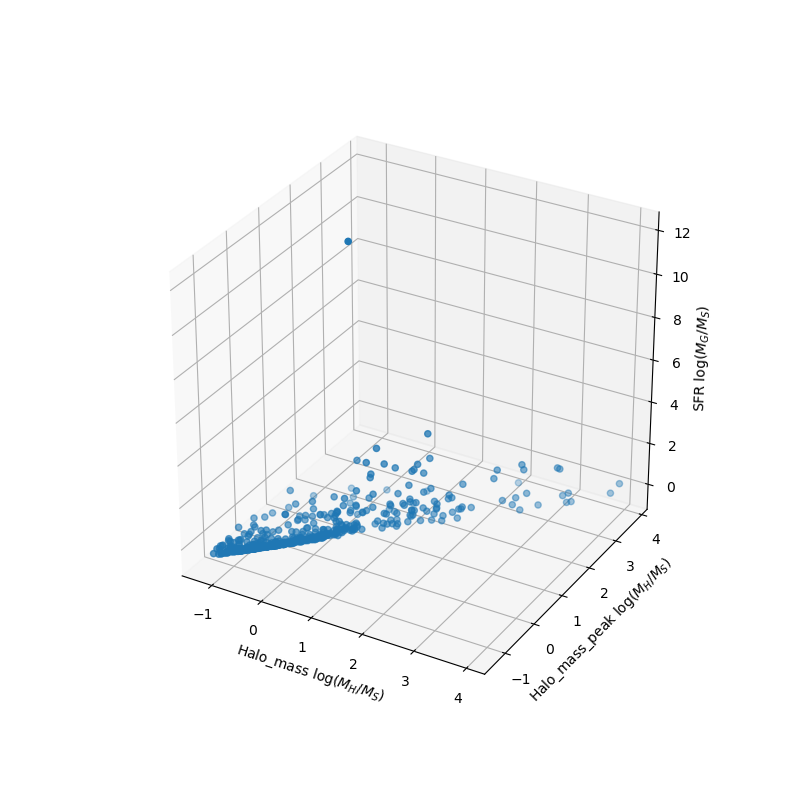

In [11]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

# Load an existing model

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

# Create a new model

In [25]:
# create model
model = Sequential()
model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    model.add(Dense(neuronsPerLayer, activation = activationFunction))

model.add(Dense(len(output_features), activation = 'relu'))

# Compile model
model.compile(loss=loss_func_dict[loss_function], metrics=['mse'], optimizer='adam')#, metrics=[loss_function])

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param)
history = model.fit(x_train_norm , y_train_norm, validation_data=(x_val_norm, y_val_norm), 
                    epochs=int(nEpochs), batch_size=int(batchSize))


Train on 270000 samples, validate on 10000 samples
Epoch 1/1000
270000/270000 [==============================] - 2s 7us/step - loss: 0.7565 - mean_squared_error: 0.7565 - val_loss: 0.6416 - val_mean_squared_error: 0.6416
Epoch 2/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.5878 - mean_squared_error: 0.5878 - val_loss: 0.5943 - val_mean_squared_error: 0.5943
Epoch 3/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.5538 - mean_squared_error: 0.5538 - val_loss: 0.5641 - val_mean_squared_error: 0.5641
Epoch 4/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.5325 - mean_squared_error: 0.5325 - val_loss: 0.5388 - val_mean_squared_error: 0.5388
Epoch 5/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.5130 - mean_squared_error: 0.5130 - val_loss: 0.5143 - val_mean_squared_error: 0.5143
Epoch 6/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.4969 - mean_squ

270000/270000 [==============================] - 1s 2us/step - loss: 0.4034 - mean_squared_error: 0.4034 - val_loss: 0.3918 - val_mean_squared_error: 0.3918
Epoch 49/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.4001 - mean_squared_error: 0.4001 - val_loss: 0.3990 - val_mean_squared_error: 0.3990
Epoch 50/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.4019 - mean_squared_error: 0.4019 - val_loss: 0.3920 - val_mean_squared_error: 0.3920
Epoch 51/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3988 - mean_squared_error: 0.3988 - val_loss: 0.3951 - val_mean_squared_error: 0.3951
Epoch 52/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3998 - mean_squared_error: 0.3998 - val_loss: 0.4017 - val_mean_squared_error: 0.4017
Epoch 53/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.4019 - mean_squared_error: 0.4019 - val_loss: 0.3956 - val_mean_squared_er

Epoch 96/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3862 - mean_squared_error: 0.3862 - val_loss: 0.3814 - val_mean_squared_error: 0.3814
Epoch 97/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3855 - mean_squared_error: 0.3855 - val_loss: 0.3782 - val_mean_squared_error: 0.3782
Epoch 98/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3860 - mean_squared_error: 0.3860 - val_loss: 0.3878 - val_mean_squared_error: 0.3878
Epoch 99/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3869 - mean_squared_error: 0.3869 - val_loss: 0.3750 - val_mean_squared_error: 0.3750
Epoch 100/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3891 - mean_squared_error: 0.3891 - val_loss: 0.3776 - val_mean_squared_error: 0.3776
Epoch 101/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3880 - mean_squared_error: 0.3880 - val_loss: 0.3877 - val

270000/270000 [==============================] - 1s 3us/step - loss: 0.3793 - mean_squared_error: 0.3793 - val_loss: 0.3723 - val_mean_squared_error: 0.3723
Epoch 144/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3761 - mean_squared_error: 0.3761 - val_loss: 0.3692 - val_mean_squared_error: 0.3692
Epoch 145/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3773 - mean_squared_error: 0.3773 - val_loss: 0.3676 - val_mean_squared_error: 0.3676
Epoch 146/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3829 - mean_squared_error: 0.3829 - val_loss: 0.3787 - val_mean_squared_error: 0.3787
Epoch 147/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3772 - mean_squared_error: 0.3772 - val_loss: 0.3682 - val_mean_squared_error: 0.3682
Epoch 148/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3784 - mean_squared_error: 0.3784 - val_loss: 0.3708 - val_mean_squar

Epoch 191/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3716 - mean_squared_error: 0.3716 - val_loss: 0.3598 - val_mean_squared_error: 0.3598
Epoch 192/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3705 - mean_squared_error: 0.3705 - val_loss: 0.3680 - val_mean_squared_error: 0.3680
Epoch 193/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3715 - mean_squared_error: 0.3715 - val_loss: 0.3625 - val_mean_squared_error: 0.3625
Epoch 194/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3690 - mean_squared_error: 0.3690 - val_loss: 0.3659 - val_mean_squared_error: 0.3659
Epoch 195/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3691 - mean_squared_error: 0.3691 - val_loss: 0.3685 - val_mean_squared_error: 0.3685
Epoch 196/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3741 - mean_squared_error: 0.3741 - val_loss: 0.3622 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3679 - mean_squared_error: 0.3679 - val_loss: 0.3664 - val_mean_squared_error: 0.3664
Epoch 239/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3664 - mean_squared_error: 0.3664 - val_loss: 0.3604 - val_mean_squared_error: 0.3604
Epoch 240/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3694 - mean_squared_error: 0.3694 - val_loss: 0.3630 - val_mean_squared_error: 0.3630
Epoch 241/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3679 - mean_squared_error: 0.3679 - val_loss: 0.3646 - val_mean_squared_error: 0.3646
Epoch 242/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.3610 - val_mean_squared_error: 0.3610
Epoch 243/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3664 - mean_squared_error: 0.3664 - val_loss: 0.3598 - val_mean_squar

Epoch 286/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3643 - mean_squared_error: 0.3643 - val_loss: 0.3555 - val_mean_squared_error: 0.3555
Epoch 287/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3641 - mean_squared_error: 0.3641 - val_loss: 0.3585 - val_mean_squared_error: 0.3585
Epoch 288/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3736 - mean_squared_error: 0.3736 - val_loss: 0.3669 - val_mean_squared_error: 0.3669
Epoch 289/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3652 - mean_squared_error: 0.3652 - val_loss: 0.3567 - val_mean_squared_error: 0.3567
Epoch 290/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3587 - mean_squared_error: 0.3587 - val_loss: 0.3613 - val_mean_squared_error: 0.3613
Epoch 291/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3588 - mean_squared_error: 0.3588 - val_loss: 0.3539 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3521 - mean_squared_error: 0.3521 - val_loss: 0.3538 - val_mean_squared_error: 0.3538
Epoch 334/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3521 - mean_squared_error: 0.3521 - val_loss: 0.3533 - val_mean_squared_error: 0.3533
Epoch 335/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3506 - mean_squared_error: 0.3506 - val_loss: 0.3541 - val_mean_squared_error: 0.3541
Epoch 336/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3520 - mean_squared_error: 0.3520 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 337/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3634 - val_mean_squared_error: 0.3634
Epoch 338/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3618 - val_mean_squar

Epoch 381/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3524 - mean_squared_error: 0.3524 - val_loss: 0.3490 - val_mean_squared_error: 0.3490
Epoch 382/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3481 - mean_squared_error: 0.3481 - val_loss: 0.3514 - val_mean_squared_error: 0.3514
Epoch 383/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3708 - val_mean_squared_error: 0.3708
Epoch 384/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3550 - val_mean_squared_error: 0.3550
Epoch 385/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3572 - mean_squared_error: 0.3572 - val_loss: 0.3641 - val_mean_squared_error: 0.3641
Epoch 386/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3596 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3458 - mean_squared_error: 0.3458 - val_loss: 0.3474 - val_mean_squared_error: 0.3474
Epoch 429/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3449 - mean_squared_error: 0.3449 - val_loss: 0.3546 - val_mean_squared_error: 0.3546
Epoch 430/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3455 - mean_squared_error: 0.3455 - val_loss: 0.3572 - val_mean_squared_error: 0.3572
Epoch 431/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3447 - mean_squared_error: 0.3447 - val_loss: 0.3517 - val_mean_squared_error: 0.3517
Epoch 432/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3438 - mean_squared_error: 0.3438 - val_loss: 0.3535 - val_mean_squared_error: 0.3535
Epoch 433/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3424 - mean_squared_error: 0.3424 - val_loss: 0.3593 - val_mean_squar

Epoch 476/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3439 - mean_squared_error: 0.3439 - val_loss: 0.3563 - val_mean_squared_error: 0.3563
Epoch 477/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3424 - mean_squared_error: 0.3424 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 478/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3402 - mean_squared_error: 0.3402 - val_loss: 0.3563 - val_mean_squared_error: 0.3563
Epoch 479/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3559 - val_mean_squared_error: 0.3559
Epoch 480/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3465 - mean_squared_error: 0.3465 - val_loss: 0.3610 - val_mean_squared_error: 0.3610
Epoch 481/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3456 - mean_squared_error: 0.3456 - val_loss: 0.3606 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3361 - mean_squared_error: 0.3361 - val_loss: 0.3618 - val_mean_squared_error: 0.3618
Epoch 524/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3528 - mean_squared_error: 0.3528 - val_loss: 0.3584 - val_mean_squared_error: 0.3584
Epoch 525/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3512 - mean_squared_error: 0.3512 - val_loss: 0.3493 - val_mean_squared_error: 0.3493
Epoch 526/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3413 - mean_squared_error: 0.3413 - val_loss: 0.3548 - val_mean_squared_error: 0.3548
Epoch 527/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3393 - mean_squared_error: 0.3393 - val_loss: 0.3605 - val_mean_squared_error: 0.3605
Epoch 528/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3812 - mean_squared_error: 0.3812 - val_loss: 0.3739 - val_mean_squar

Epoch 571/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3699 - val_mean_squared_error: 0.3699
Epoch 572/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3479 - mean_squared_error: 0.3479 - val_loss: 0.3728 - val_mean_squared_error: 0.3728
Epoch 573/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3398 - mean_squared_error: 0.3398 - val_loss: 0.3742 - val_mean_squared_error: 0.3742
Epoch 574/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3527 - mean_squared_error: 0.3527 - val_loss: 0.3704 - val_mean_squared_error: 0.3704
Epoch 575/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3411 - mean_squared_error: 0.3411 - val_loss: 0.3583 - val_mean_squared_error: 0.3583
Epoch 576/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3366 - mean_squared_error: 0.3366 - val_loss: 0.3536 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3843 - val_mean_squared_error: 0.3843
Epoch 619/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3690 - mean_squared_error: 0.3690 - val_loss: 0.3672 - val_mean_squared_error: 0.3672
Epoch 620/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3491 - mean_squared_error: 0.3491 - val_loss: 0.3581 - val_mean_squared_error: 0.3581
Epoch 621/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3449 - mean_squared_error: 0.3449 - val_loss: 0.3647 - val_mean_squared_error: 0.3647
Epoch 622/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3350 - mean_squared_error: 0.3350 - val_loss: 0.3639 - val_mean_squared_error: 0.3639
Epoch 623/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3414 - mean_squared_error: 0.3414 - val_loss: 0.3637 - val_mean_squar

Epoch 666/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3372 - mean_squared_error: 0.3372 - val_loss: 0.3579 - val_mean_squared_error: 0.3579
Epoch 667/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3326 - mean_squared_error: 0.3326 - val_loss: 0.3736 - val_mean_squared_error: 0.3736
Epoch 668/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3270 - mean_squared_error: 0.3270 - val_loss: 0.3602 - val_mean_squared_error: 0.3602
Epoch 669/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3347 - mean_squared_error: 0.3347 - val_loss: 0.3994 - val_mean_squared_error: 0.3994
Epoch 670/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3467 - mean_squared_error: 0.3467 - val_loss: 0.3871 - val_mean_squared_error: 0.3871
Epoch 671/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3458 - mean_squared_error: 0.3458 - val_loss: 0.3645 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3279 - mean_squared_error: 0.3279 - val_loss: 0.3785 - val_mean_squared_error: 0.3785
Epoch 714/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3522 - mean_squared_error: 0.3522 - val_loss: 0.3838 - val_mean_squared_error: 0.3838
Epoch 715/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3457 - mean_squared_error: 0.3457 - val_loss: 0.3417 - val_mean_squared_error: 0.3417
Epoch 716/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3457 - mean_squared_error: 0.3457 - val_loss: 0.3639 - val_mean_squared_error: 0.3639
Epoch 717/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3393 - mean_squared_error: 0.3393 - val_loss: 0.3693 - val_mean_squared_error: 0.3693
Epoch 718/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3689 - val_mean_squar

Epoch 761/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3220 - mean_squared_error: 0.3220 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 762/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3284 - mean_squared_error: 0.3284 - val_loss: 0.3441 - val_mean_squared_error: 0.3441
Epoch 763/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3346 - mean_squared_error: 0.3346 - val_loss: 0.3519 - val_mean_squared_error: 0.3519
Epoch 764/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3397 - mean_squared_error: 0.3397 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 765/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3301 - mean_squared_error: 0.3301 - val_loss: 0.3659 - val_mean_squared_error: 0.3659
Epoch 766/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3304 - mean_squared_error: 0.3304 - val_loss: 0.3740 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3197 - mean_squared_error: 0.3197 - val_loss: 0.3645 - val_mean_squared_error: 0.3645
Epoch 809/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3184 - mean_squared_error: 0.3184 - val_loss: 0.3593 - val_mean_squared_error: 0.3593
Epoch 810/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3203 - mean_squared_error: 0.3203 - val_loss: 0.3788 - val_mean_squared_error: 0.3788
Epoch 811/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3243 - mean_squared_error: 0.3243 - val_loss: 0.3549 - val_mean_squared_error: 0.3549
Epoch 812/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3255 - mean_squared_error: 0.3255 - val_loss: 0.3618 - val_mean_squared_error: 0.3618
Epoch 813/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3283 - mean_squared_error: 0.3283 - val_loss: 0.3736 - val_mean_squar

Epoch 856/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3240 - mean_squared_error: 0.3240 - val_loss: 0.3475 - val_mean_squared_error: 0.3475
Epoch 857/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3318 - mean_squared_error: 0.3318 - val_loss: 0.3633 - val_mean_squared_error: 0.3633
Epoch 858/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3332 - mean_squared_error: 0.3332 - val_loss: 0.3358 - val_mean_squared_error: 0.3358
Epoch 859/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3287 - mean_squared_error: 0.3287 - val_loss: 0.3977 - val_mean_squared_error: 0.3977
Epoch 860/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3246 - mean_squared_error: 0.3246 - val_loss: 0.3646 - val_mean_squared_error: 0.3646
Epoch 861/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3205 - mean_squared_error: 0.3205 - val_loss: 0.3952 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3258 - mean_squared_error: 0.3258 - val_loss: 0.3924 - val_mean_squared_error: 0.3924
Epoch 904/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3231 - mean_squared_error: 0.3231 - val_loss: 0.4101 - val_mean_squared_error: 0.4101
Epoch 905/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3413 - mean_squared_error: 0.3413 - val_loss: 0.3951 - val_mean_squared_error: 0.3951
Epoch 906/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3321 - mean_squared_error: 0.3321 - val_loss: 0.3969 - val_mean_squared_error: 0.3969
Epoch 907/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3429 - mean_squared_error: 0.3429 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 908/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3273 - mean_squared_error: 0.3273 - val_loss: 0.3922 - val_mean_squar

Epoch 951/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3189 - mean_squared_error: 0.3189 - val_loss: 0.3689 - val_mean_squared_error: 0.3689
Epoch 952/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3174 - mean_squared_error: 0.3174 - val_loss: 0.3420 - val_mean_squared_error: 0.3420
Epoch 953/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3180 - mean_squared_error: 0.3180 - val_loss: 0.3474 - val_mean_squared_error: 0.3474
Epoch 954/1000
270000/270000 [==============================] - 1s 2us/step - loss: 0.3170 - mean_squared_error: 0.3170 - val_loss: 0.3764 - val_mean_squared_error: 0.3764
Epoch 955/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3218 - mean_squared_error: 0.3218 - val_loss: 0.3455 - val_mean_squared_error: 0.3455
Epoch 956/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3281 - mean_squared_error: 0.3281 - val_loss: 0.3912 -

270000/270000 [==============================] - 1s 3us/step - loss: 0.3172 - mean_squared_error: 0.3172 - val_loss: 0.3416 - val_mean_squared_error: 0.3416
Epoch 999/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3163 - mean_squared_error: 0.3163 - val_loss: 0.3640 - val_mean_squared_error: 0.3640
Epoch 1000/1000
270000/270000 [==============================] - 1s 3us/step - loss: 0.3139 - mean_squared_error: 0.3139 - val_loss: 0.3594 - val_mean_squared_error: 0.3594


# Plot loss history

In [32]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


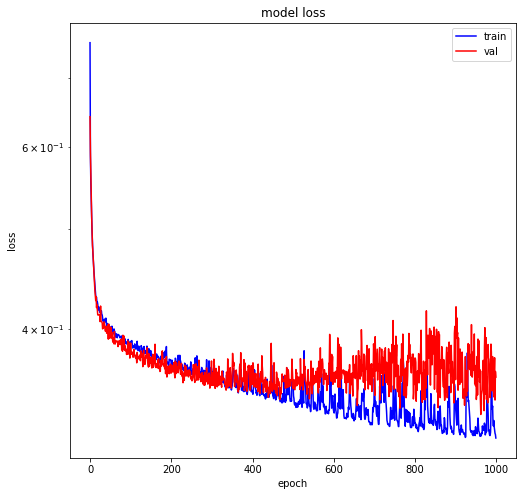

In [26]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Evaluate the model

In [28]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

MSE for the processed data: 0.4362


In [29]:
### Predict real value of points
if norm == 'zero_mean_unit_std_norm':
    predicted_norm_points = model.predict(x_test_norm)
    predicted_points = predicted_norm_points * y_data_stds + y_data_means
    
if norm == 'zero_to_one_norm':
    predicted_norm_points = model.predict(x_test_norm)
    predicted_points = predicted_norm_points * (y_data_max - y_data_min) + y_data_min


In [30]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

MSE for the unprocessed data: 0.3493


# Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

# Scatterplots and boxplots

OSError: [Errno 36] File name too long: 'figures/bp_output_scatter_1_plot_from_Halo_mass_and_Halo_mass_peak_and_Concentration_and_Type_and_Scale_peak_mass_and_Scale_half_mass_and_Scale_last_MajM_to_Stellar_mass_and_SFR_with_nLayers_20_nNeurons_20_actFun_tanh_lossFunc_mse_nTrainSamples_270000_nEpochs_1000_batchSize_10000.png'

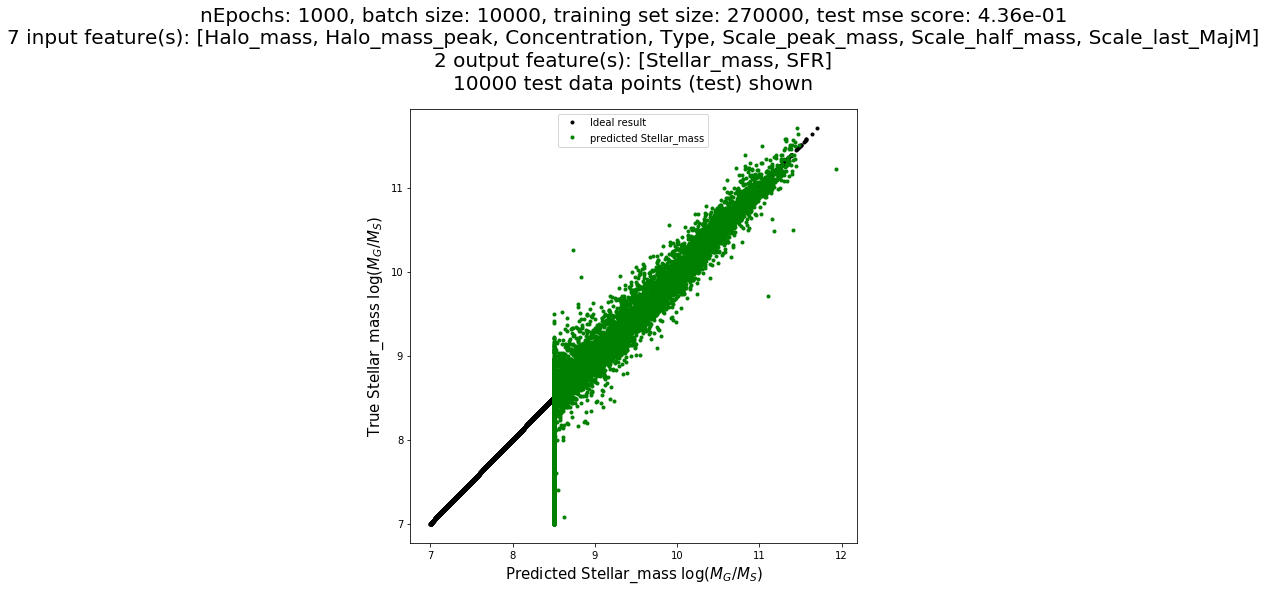

In [31]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    plt.show
        
    if save_figs:
        fig.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
        
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    
    plt.show()
    
    if save_figs:
        fig.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

# Scatterplots and plots with errorbars

OSError: [Errno 36] File name too long: 'figures/bp_output_scatter_1_plot_from_Halo_mass_and_Halo_mass_peak_and_Concentration_and_Type_and_Scale_peak_mass_and_Scale_half_mass_and_Scale_last_MajM_to_Stellar_mass_and_SFR_with_nLayers_20_nNeurons_20_actFun_tanh_lossFunc_mse_nTrainSamples_270000_nEpochs_1000_batchSize_10000.png'

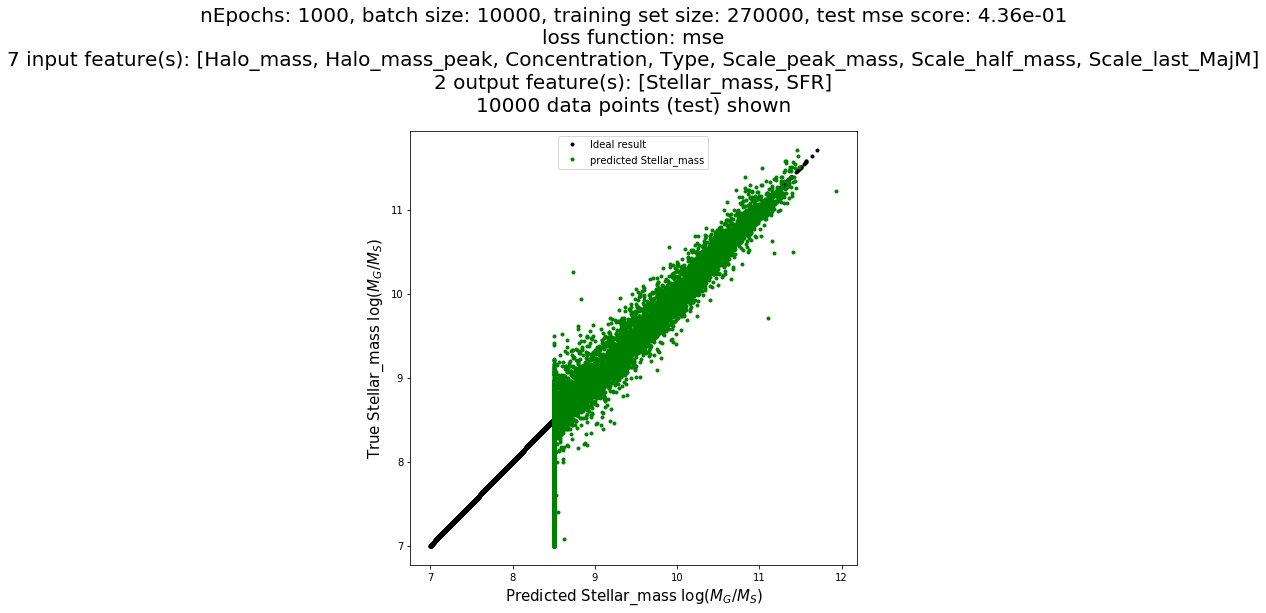

In [32]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    plt.show
        
    if save_figs:
        fig.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    # get standard deviations of the binned values
    stds_true = np.zeros((nBins))
    stds_pred = np.zeros((nBins))
    for iBin in range(nBins):
        stds_true[iBin] = np.std(sorted_true_y_data[iBin])
        stds_pred[iBin] = np.std(sorted_pred_y_data[iBin])
        
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every plot adds 2 distributions, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.errorbar(bin_pos[0], bin_means_true[0][iBin], yerr=stds_true[iBin], fmt = 'bo', capsize=5)
        plt.errorbar(bin_pos[1], bin_means_pred[0][iBin], yerr=stds_pred[iBin], fmt = 'ro', capsize=5)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    plt.legend(['True data $\pm 1 \sigma$', 'Predicted data $\pm 1 \sigma$'], loc='upper left', fontsize='xx-large')
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    
    plt.show()
    
    if save_figs:
        fig.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
#print(predictedY.flatten())
#bin_means = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10)
#bin_stds = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10, statistic=GetSTD)
#print(bin_means[0])
#print(bin_stds[0])

# Plot SFR vs Stellar mass

<function matplotlib.pyplot.show>

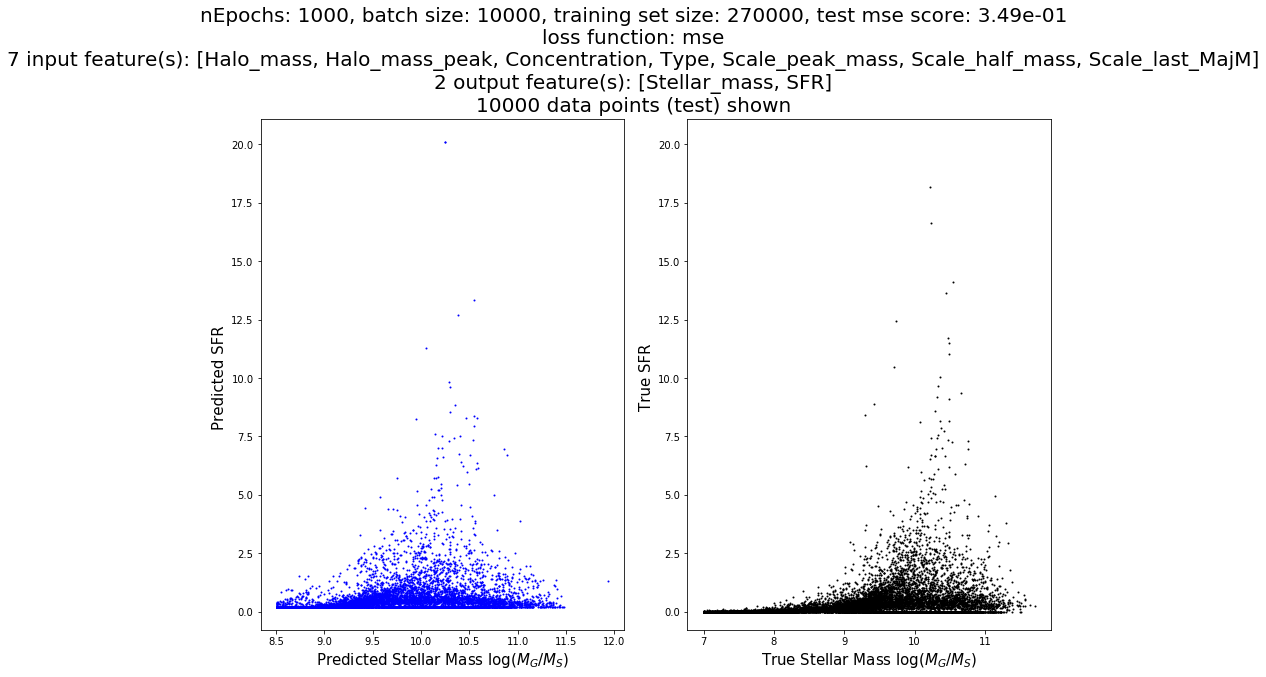

In [33]:
predictedY = model.predict(x_test_norm)
predictedY = predictedY * y_data_stds + y_data_means

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(121)

plt.plot(predictedY[:,0], predictedY[:,1], 'b.', markersize=2)
plt.ylabel('Predicted SFR %s' % (unit_dict['SFR']), fontsize=15)
plt.xlabel('Predicted Stellar Mass %s' % (unit_dict['Stellar_mass']), fontsize=15)
ymin, ymax = ax.get_ylim()
ax.set_ylim(bottom=ymin, top=ymax)

ax = plt.subplot(122)
plt.plot(y_test[:,0], y_test[:,1], 'k.', markersize=2)
plt.ylabel('True SFR %s' % (unit_dict['SFR']), fontsize=15)
plt.xlabel('True Stellar Mass %s' % (unit_dict['Stellar_mass']), fontsize=15)
ax.set_ylim(bottom=ymin, top=ymax)
plt.suptitle('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    batchSize, train_size, total_score) + 'loss function: %s\n' % (loss_function) +
    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    test_size), y=1.17, fontsize=20)
plt.tight_layout()
plt.show

In [46]:
### Save the figure
fig.savefig(fig_dir+'bp_sfr_to_stellar_mass_inputs_' + '_and_'.join(input_features)+
            '_with_'+param_string+'.png', bbox_inches = 'tight')

# Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())